In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, \
Conv3D,MaxPooling3D,Input,GlobalAveragePooling3D, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def testers(lr,channels,model,epochs=100,verb=1,batch_size=30):
#     model = get_model(width=42,height=300,depth=6,activation='relu',dense_activation=dense_act,
#                   dropout_rate=0.3)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    num_epochs = epochs
    X_test_res = X_test[:,:,:,channels]
    history = model.fit(X_train[:,:,:,channels],y_train[:], epochs = num_epochs, batch_size=batch_size,\
                        shuffle=True, verbose=verb,validation_data=(X_test_res,y_test[:]))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    #plt.xlim(0,50)
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test_res,y_test[:],' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 
    
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [2]:
# X_train = np.load('CWT-D/X_train_s.npy')
# X_test = np.load('CWT-D/X_test_s.npy')
# y_train = np.load('CWT-D/y_train_s.npy')
# y_test = np.load('CWT-D/y_test_s.npy')
path ='Pre-Dat/Fp1-F3-P4-O2-A1-T3'
extension = ''
X_train = np.load(path+'/X_train'+f'{extension}.npy')
X_test = np.load(path+'/X_test'+f'{extension}.npy')
y_train = np.load(path+'/y_train'+f'{extension}.npy')
y_test = np.load(path+'/y_test'+f'{extension}.npy')

In [3]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (3616, 90, 200, 6, 1)
y train shape: (3616, 3)
X test shape: (896, 90, 200, 6, 1)
y test shape: (896, 3)


In [4]:
def get_model(width=38, height=300, depth=6,activation='sigmoid',dense_activation='sigmoid',dropout_rate=0.0,NORM=True):
    """Build a 3D convolutional neural network model."""
    model = Sequential()
    
    model.add(Input((width, height, depth, 1)))

    model.add(Conv3D(filters=72/2, kernel_size=3,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=128/2, kernel_size=3,padding='valid',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=256/2, kernel_size=3,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=256/2, kernel_size=3,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    if NORM:
        model.add(BatchNormalization())
    
#     model.add(Conv3D(filters=72, kernel_size=3,padding='same',activation=activation))
#     model.add(MaxPooling3D(pool_size=(2,2,1)))
#     if NORM:
#         model.add(BatchNormalization())
    
#     model.add(Conv3D(filters=72, kernel_size=3,padding='same',activation=activation))
#     model.add(MaxPooling3D(pool_size=(2,2,2)))
#     if NORM:
#         model.add(BatchNormalization())

#     model.add(GlobalAveragePooling3D())
    units_in = 512
    model.add(Flatten())
    model.add(Dense(units=units_in, activation=dense_activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=int(units_in/2), activation=dense_activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=int(units_in/4), activation=dense_activation))
    model.add(Dropout(dropout_rate))

#     model.add(Dense(units=int(units_in/8), activation=dense_activation))
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=int(units_in/16), activation='tanh'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=3,kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    model.add(Activation('softmax',name='CNN_EEGModel'))
    return model

In [5]:
def MLP (input_shape, num_classes,activation, dropout,batch_normalization,dropout_rate):
    model = Sequential()
    
    #LSTM layers
    # model.add(LSTM(400, input_shape= X_train.shape[1:], return_sequences = False))
    # model.add(Dropout(0.2))
    # for _ in range(20):
    #     model.add(LSTM(400, activation='tanh', return_sequences=True))
    #     model.add(Dropout(0.1))

    #Dense
    model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1:])))
    model.add(Dense(100,kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(dropout_rate))
    model.add(Dense(100, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation('tanh'))
    if batch_normalization:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Activation('softmax',name='CNN_EEGModel'))
    return model

def architecture(input_shape, num_classes, activation, dropout=True, batch_normalization=True):
    vpm=300
    model = Sequential()
    
    model.add(Conv2D(32, 7, padding='same', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())

    model.add(Conv2D(32, 3, padding='valid', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    model.add(Conv2D(32, 3, padding='same', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
        
    model.add(Conv2D(32, 3, padding='valid', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization()) 
        
    model.add(Flatten())
    if dropout:
        model.add(Dropout(0.30))
    
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation('relu'))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Activation(activation,name='CNN_EEGModel'))
    
    return model

In [6]:
model = get_model(width=90,height=200,depth=6,activation='relu',dense_activation='sigmoid',dropout_rate=0.2)
# model = architecture(input_shape=(90,200,1),activation='sigmoid',num_classes=3,dropout=True,batch_normalization=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 90, 200, 6, 36)    1008      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 45, 100, 6, 36)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 45, 100, 6, 36)   144       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 43, 98, 4, 64)     62272     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 21, 49, 4, 64)    0         
 3D)                                                             
                                                        

In [7]:
keras_model_memory_usage_in_bytes(model,batch_size=2)

75810291

Epoch 1/50
121/121 [==============================] - 28s 146ms/step - loss: 1.1527 - accuracy: 0.3424 - val_loss: 1.1024 - val_accuracy: 0.3449
Epoch 2/50
121/121 [==============================] - 16s 136ms/step - loss: 1.1177 - accuracy: 0.3576 - val_loss: 1.1005 - val_accuracy: 0.3750
Epoch 3/50
121/121 [==============================] - 16s 136ms/step - loss: 1.0852 - accuracy: 0.3913 - val_loss: 1.0874 - val_accuracy: 0.4007
Epoch 4/50
121/121 [==============================] - 17s 137ms/step - loss: 1.0702 - accuracy: 0.4151 - val_loss: 1.0845 - val_accuracy: 0.3973
Epoch 5/50
121/121 [==============================] - 17s 138ms/step - loss: 1.0554 - accuracy: 0.4226 - val_loss: 1.0848 - val_accuracy: 0.3984
Epoch 6/50
121/121 [==============================] - 17s 138ms/step - loss: 1.0483 - accuracy: 0.4212 - val_loss: 1.0794 - val_accuracy: 0.3951
Epoch 7/50
121/121 [==============================] - 16s 133ms/step - loss: 1.0323 - accuracy: 0.4331 - val_loss: 1.0809 - val_ac

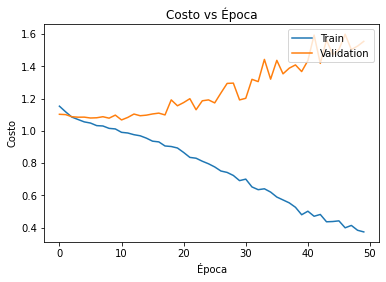

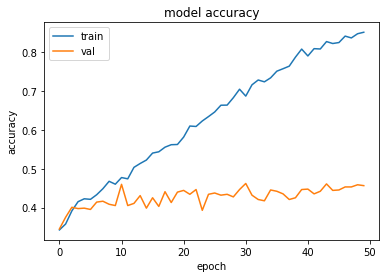

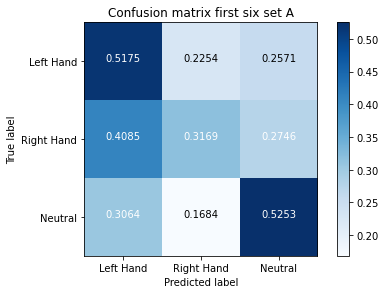

In [8]:
testers(1e-3,range(6),epochs=50,model=model)